In [1]:
import sys
import os

from Networks.multi_layer_net_extend import MultiLayerNetExtend as MLE
from Networks.simple_convnet import SimpleConvNet as CVS
from Networks.deep_convnet import DeepConvNet as CVD
from Networks.VGG import VGG
from Networks.CNN import CNN

import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from Layers.optimizer import *
from Layers.util import smooth_curve
import cupy as np
import time


In [2]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
train_size = x_train.shape[0]
test_size = x_test.shape[0]
batch_size = 128
max_iterations = 100
print_iter = 10
mi = np.arange(max_iterations)

In [3]:
def test(test_list, max_acc=None):
    networks = {}
    train_acc = {}
    train_loss = {}
    test_acc = {}
    test_loss = {}
    optimizer = {}
    total_step = {}
    time_record = {}

    for key in test_list.keys():
        # 기록 리스트 생성
        train_acc[key] = []
        train_loss[key] = []
        test_acc[key] = []
        test_loss[key] = []
        total_step[key] = 0
        time_record[key] = 0

        # nSigmoid 경우 파라미터
        # key == 'nSigmoid_8' -> act = nSigmoid, threshold = 8
        networks[key] = test_list[key]['network']

        # optimizer 생성
        opt = test_list[key]['opt']
        lr = test_list[key]['lr']
        if opt == 'SGD':
            optimizer[key] = SGD(lr)
        elif opt == 'Momentum':
            optimizer[key] = Momentum(lr)
        elif opt == 'AdaGrad':
            optimizer[key] = AdaGrad(lr)
        elif opt == 'Adam':
            optimizer[key] = Adam(lr)
        else:
            assert 'no opt' + opt

    # 파라미터 통일 셋팅
    # networks1 = networks['CVD']
    # networks2 = networks['CNN']
    # for k in networks1.params.keys():
    #     for i in range(networks1.params[k].shape[0]):
    #         networks1.params[k][i] = networks2.params[k][i].copy()
    # print(networks['CVD'].params['W1'] - networks['CNN'].params['W1'])
    # 학습
    for i in range(max_iterations):
        if 0 not in total_step.values():
            print("All test list training Done\nStep: " + str(i))
            break

        # mini-batch train
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        # mini-batch test
        batch_mask_t = np.random.choice(test_size, batch_size)
        x_batch_t = x_test[batch_mask_t]
        t_batch_t = t_test[batch_mask_t]

        # print_iter 회마다 경과 출력
        if i % print_iter == 0:
            print( "="*15 + "iteration:" + str(i) + "="*15)
            print("{:^9}|{:^9}|{:^9}|{:^9}".format('model','time','acc','loss'))

        # 학습 & 추론 & 기록
        for key in test_list.keys():
            if total_step[key] != 0:
                # Max acc 에 도달해 학습이 끝난 test model
                continue
            else:
                start = time.time()
                # CV 모델 데이터 처리
                if isinstance(networks[key], (CVS, CVD, CNN, VGG)):
                    x_batch = x_batch.reshape(-1, 1, 28, 28)
                    x_batch_t = x_batch_t.reshape(-1, 1, 28, 28)

                # 학습(역전파)
                grads = networks[key].gradient(x_batch, t_batch)
                optimizer[key].update(networks[key].params, grads)

                # 추론(순전파)
                tr_acc, tr_loss = networks[key].acc_and_loss(x_batch, t_batch)
                ts_acc, ts_loss = networks[key].acc_and_loss(x_batch_t, t_batch_t)

                # 기록
                train_acc[key].append(tr_acc)
                train_loss[key].append(tr_loss)
                test_acc[key].append(ts_acc)
                test_loss[key].append(ts_loss)
                end = time.time()
                time_record[key] += (end-start)

                # max accuracy 도달 해당 모델 학습 종료
                if max_acc and max_acc <= ts_acc:
                    total_step[key] = i
                    print(key + " training end!\nacc : " + str(ts_acc) + " step: " + str(i))

                # print_iter 회마다 경과 출력
                if i % print_iter == 0:
                    print("{:^9}| {:0<7.3f} | {:0<.5f} | {:0<.5f}".format(key, time_record[key], ts_acc, ts_loss))

    return train_acc, train_loss, test_acc, test_loss, total_step


def plot(label, datas, t_list, *y_lim):
    for key in t_list:
        plt.plot( smooth_curve(datas[key]), markevery=50, label=key)
    plt.xlabel("iterations")
    plt.ylabel(label)
    if y_lim:
        plt.ylim(y_lim)
    plt.legend()
    plt.show()

In [4]:
net1 = MLE(input_size=784, hidden_size_list=[100, 100, 100, 100], output_size=10,
            use_dropout=True, dropout_ratio=0.5,
            activation='relu', weight_init_std='he', use_batchnorm=False)
net2 = CNN()
# net3 = VGG()

In [5]:
test_list = {
             'MLP':
                 {'network':net1,'opt':'AdaGrad','lr':0.01},
             'CNN':
                 {'network':net2,'opt':'AdaGrad','lr':0.01},
             # 'VGG':
             #     {'network':net3,'opt':'AdaGrad','lr':0.01},
             }

# train_acc, train_loss, test_acc, test_loss, total_step = test(test_list)
train_acc, train_loss, test_acc, test_loss, total_step = test(test_list, 0.98)

===============iteration:0===============
  model  |  time   |   acc   |  loss   
   MLP   | 7.02200 | 0.14062 | 2.28907
   CNN   | 0.61200 | 0.08594 | 11.40796
===============iteration:10===============
  model  |  time   |   acc   |  loss   
   MLP   | 7.58400 | 0.41406 | 2.18174
   CNN   | 3.04700 | 0.40625 | 2.13263
===============iteration:20===============
  model  |  time   |   acc   |  loss   
   MLP   | 8.18000 | 0.40625 | 1.89432
   CNN   | 5.47600 | 0.39844 | 2.07239
===============iteration:30===============
  model  |  time   |   acc   |  loss   
   MLP   | 8.75500 | 0.38281 | 1.71367
   CNN   | 7.88900 | 0.84375 | 0.56907
===============iteration:40===============
  model  |  time   |   acc   |  loss   
   MLP   | 9.34600 | 0.45312 | 1.54015
   CNN   | 10.3010 | 0.85938 | 0.41326
===============iteration:50===============
  model  |  time   |   acc   |  loss   
   MLP   | 9.92100 | 0.49219 | 1.43018
   CNN   | 12.7090 | 0.85156 | 0.46475
===============iteration:60=======


KeyboardInterrupt



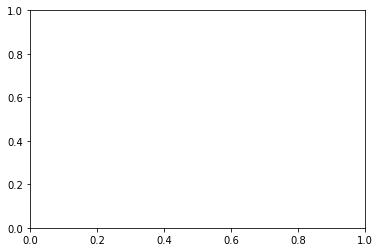

In [6]:
plot('test_acc', test_acc, test_list)

In [ ]:
plot('test_loss', test_loss, test_list)

In [ ]:
print(total_step)